In [1]:
import json
from model_api import eval_metric_model, yagpt_lite
from post_process import post_process_yagpt_lite
from tqdm import tqdm
import numpy as np
import time
import os
import utils

iam_token = 't1.9euelZqakMiMycmQyonJzI-em86eju3rnpWaz42dm4uLzouOlsfMypLLyZfl8_cgLBlU-e9zKWtL_d3z92BaFlT573Mpa0v9zef1656VmsmOy8mYkYrHyJ6cz4mNzo2b7_zF656VmsmOy8mYkYrHyJ6cz4mNzo2b.I8He5SiXbq_ytxMcxdhNBDIWxHdmpZemBhQO9AvODnZnVv13omJYSSywiy9PqivGmBvtRTP3-p2nnuWoi2fIAQ'

In [2]:
with open('test_articles_clear_100.json', 'r') as fin:
    test_articles = [json.loads(s) for s in fin.readlines()]

## YaGPT Lite

In [3]:
model_name = 'yagpt_lite'
output_file = f'test_results_{model_name}.json'
skip = 0
n_generations = 1
sleep_time = 5

def generation_fn(article):
    summary = yagpt_lite(article, iam_token, temperature=0.1)
    return summary


results = []

In [4]:
skip = len(results)
print(f"Skip={skip}")
print(f"Total data samples={len(test_articles)}")
print(f"Writing results to {output_file}, file_exists={os.path.isfile(output_file)}")

assert n_generations == 1, "n_generations > 1 is not supported yet"

with open(output_file, 'a') as f:
    for idx, sample in enumerate(tqdm(test_articles, position=0)):
        if idx < skip:
            print(f"Skip {idx}")
            continue
        
        # make N generations to statistically estimate the quality
        eval_scores = []
        eval_scores_dash = []
        summaries = []
        for _ in range(n_generations):
            article = sample['Text']

            try:
                summary = generation_fn(article)
                summary_cleaned = post_process_yagpt_lite(summary, add_dash=False)
                summary_cleaned_dash = post_process_yagpt_lite(summary, add_dash=True)

                eval_score = eval_metric_model(article, summary_cleaned)
                eval_score_dash = eval_metric_model(article, summary_cleaned_dash)
            except AssertionError as e:
                print(e)
                time.sleep(60)

                summary = generation_fn(article)
                summary_cleaned = post_process_yagpt_lite(summary, add_dash=False)
                summary_cleaned_dash = post_process_yagpt_lite(summary, add_dash=True)

                eval_score = eval_metric_model(article, summary_cleaned)
                eval_score_dash = eval_metric_model(article, summary_cleaned_dash)

            eval_scores.append(eval_score)
            eval_scores_dash.append(eval_score_dash)
            summaries.append(summary)
            time.sleep(sleep_time)

        result = {
            'idx': idx,
            'id': sample.get('id', None),
            'eval_scores': eval_scores,
            'eval_scores_dash': eval_scores_dash,
            'summaries': summaries,
            'summaries_cleaned': [summary_cleaned],
            'summaries_cleaned_dash': [summary_cleaned_dash],
        }

        f.write(json.dumps(result, ensure_ascii=False) + '\n')
        f.flush()

        results.append(result)

        # print(f"Eval score stats: {idx=}, {mean=}, {std=}")

Skip=0
Total data samples=100
Writing results to test_results_yagpt_lite.json, file_exists=True


 47%|████▋     | 47/100 [07:56<09:05, 10.29s/it]

Error: 429, {"error":{"grpcCode":8,"httpCode":429,"message":"ai.textGenerationCompletionSessionsCount.count gauge quota limit exceed: allowed 3 requests","httpStatus":"Too Many Requests","details":[]}}


 48%|████▊     | 48/100 [09:07<24:40, 28.48s/it]

Error: 429, {"error":{"grpcCode":8,"httpCode":429,"message":"ai.textGenerationCompletionSessionsCount.count gauge quota limit exceed: allowed 3 requests","httpStatus":"Too Many Requests","details":[]}}


 71%|███████   | 71/100 [13:56<05:15, 10.88s/it]

Error: 400, {"error":{"grpcCode":3,"httpCode":400,"message":"An answer to a given topic cannot be generated","httpStatus":"Bad Request","details":[]}}


100%|██████████| 100/100 [20:01<00:00, 12.01s/it]


In [ ]:
# results = utils.load_jsonl(output_file)

In [6]:
# remove extra spaces in summary_cleaned using regex
import re
for idx, result in enumerate(results):
    summary_cleaned = result['summaries_cleaned'][0]
    summary_cleaned = re.sub(r'\s+', ' ', summary_cleaned)
    id = result['id']
    article = test_articles[idx]['Text']
    assert id == test_articles[idx]['id'], f"{id=}, {test_articles[idx]['id']=}"
    
    # eval
    eval_score_2 = eval_metric_model(article, summary_cleaned)
    result['summaries_cleaned_2'] = [summary_cleaned]
    result['eval_scores_2'] = [eval_score_2]


In [9]:
scores = [r['eval_scores'][0] for r in results]
scores_dash = [r['eval_scores_dash'][0] for r in results]
scores_2 = [r['eval_scores_2'][0] for r in results]
print(f"Mean score={np.mean(scores)}")
print(f"Mean score dash={np.mean(scores_dash)}")
print(f"Mean score 2={np.mean(scores_2)}")

Mean score=0.54217836
Mean score dash=0.5330401600000001
Mean score 2=0.54197143


In [23]:
scores = [r['eval_scores'][0] for r in results]
scores_dash = [r['eval_scores_dash'][0] for r in results]
scores_2 = [r['eval_scores_2'][0] for r in results]
print(f"Mean score={np.mean(scores)}")
print(f"Mean score dash={np.mean(scores_dash)}")
print(f"Mean score 2={np.mean(scores_2)}")

Mean score=0.54217836
Mean score dash=0.5330401600000001
Mean score 2=0.54537477


In [10]:
# save results
def dump_jsonl(data, file_path):
    with open(file_path, 'w') as fout:
        for line in data:
            fout.write(json.dumps(line, ensure_ascii=False) + '\n')
# add _2 to the file name
output_file_2 = output_file.replace('.json', '_2.json')
dump_jsonl(results, output_file_2)

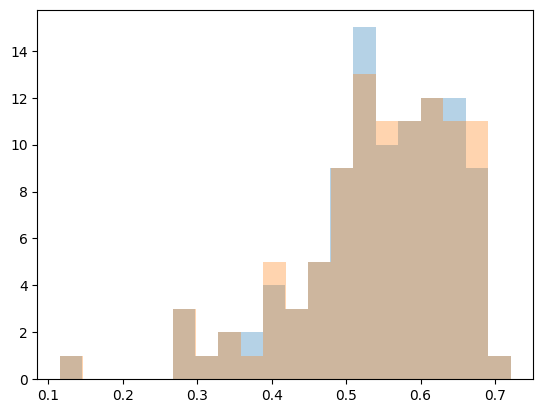

In [24]:
from matplotlib import pyplot as plt
plt.hist(scores, bins=20, alpha=0.33);
# plt.hist(scores_dash, bins=20, alpha=0.33);
plt.hist(scores_2, bins=20, alpha=0.33);

In [25]:
# calculate median
print(f"Median score={np.median(scores)}")
print(f"Median score dash={np.median(scores_dash)}")
print(f"Median score 2={np.median(scores_2)}")

Median score=0.55542
Median score dash=0.543701
Median score 2=0.5559084999999999


In [21]:
# get first item with mean score < 0.3
for r in results:
    if np.mean(r['eval_scores_2']) < 0.3:
        print(r['idx'])
        print(r['eval_scores_2'], r['eval_scores'], r['eval_scores_dash'])
        print(r['summaries_cleaned_2'])

3
[0.288818] [0.280518] [0.288818]
['Стабилизатор "Штиль Инстаб 500" разработан специально для проекта Lamptest.ru и выдает стабильное переменное напряжение 230 В с точностью ±0.6 В. Стабилизаторы сетевого напряжения используются для улучшения качества сетевого напряжения и предотвращения его понижения или повышения. Стабилизаторы "Штиль Инстаб 500" работают по принципу двойного преобразования: сначала сетевое напряжение выпрямляется, а потом преобразуется в синусоидальное переменное напряжение. Стабилизатор имеет КПД 96%, коэффициент нелинейных искажений 1.5% и является "улучшителем" коэффициента мощности. Стабилизатор был протестирован с помощью ЛАТРа, который позволяет плавно менять напряжение в широких пределах. При любых изменениях входного напряжения стабилизатор выдает стабильное выходное напряжение, независимо от входного напряжения. Стабилизатор имеет защиту от перегрузки и отключается при выходе входного напряжения за пределы стабилизации. Стабилизатор издает тихий зудящий зв

In [22]:
def remove_prompt(summary):
    summary_cleaned = summary
    summary_cleaned = summary_cleaned.replace('Основные мысли статьи:\n\n', '').strip()
    summary_cleaned = summary_cleaned.replace('Основные мысли статьи:', '').strip()
    summary_cleaned = summary_cleaned.replace('Основные мысли из статьи:', '').strip()
    is_prompt = summary_cleaned != summary
    return summary_cleaned, is_prompt

# remove prompt in every summary
for idx, r in enumerate(results):
    summary = r['summaries_cleaned_2'][0]
    summary_cleaned, is_prompt = remove_prompt(summary)
    if is_prompt:
        id = r['id']
        article = test_articles[idx]['Text']
        assert id == test_articles[idx]['id'], f"{id=}, {test_articles[idx]['id']=}"
        
        # eval
        old_eval_score_2 = r['eval_scores_2'][0]
        eval_score_2 = eval_metric_model(article, summary_cleaned)

        r['summaries_cleaned_2'] = [summary_cleaned]
        r['eval_scores_2'] = [eval_score_2]
        print(summary)
        print(summary_cleaned)
        print(f"+{eval_score_2 - old_eval_score_2:.4f}")

# save results
dump_jsonl(results, output_file_2)

In [26]:
# make paired t-test
from scipy.stats import ttest_rel
ttest_rel(scores_2, scores)

Ttest_relResult(statistic=-4.004812318365176, pvalue=0.0001201310448210316)